# Question
The following figures show the Di Wang Tower in Shenzhen. The structure of Di Wang Tower is made up of steel and reinforced concrete (calculated as reinforced concrete), C terrain type, the design wind pressure $w_0 = 0.75 \text{ kN/m}^2$, period $T_1=6.38\text{ s}$, The first mode shape is listed in following table. To determine shape factor, the cross section could be considered as rectangle.

<center>
    <img src="./images/Diwang01.png" alt="The Elvation of the DiWang Tower" width="400"/>
    <img src="./images/Diwang02.png" alt="The Plan View of the DiWang Tower" width="400"/>
</center>

<br>

| $\dfrac{h}{H}$ | 0     | 0.1   | 0.2   | 0.3   | 0.4    | 0.5   | 0.6   | 0.7    | 0.8   | 0.9   | 1.0   |
| -------------- | ----- | ----- | ----- | ----- | ------ | ----- | ----- | ------ | ----- | ----- | ----- |
| Mode shape     | 0.0000| 0.0137| 0.0558| 0.1277| 0.2424| 0.3503| 0.4629| 0.5903| 0.7309| 0.8700| 1.0000| 
| Mass / ton     | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 1500  | 

Only consider the first mode, calculate **the extreme of top displacements** induced by the along-wind static and dynamic wind load in the given wind direction using the following methods:
1. Method recommended by the Chinese code for wind-resistant design of buildings (GB 50009-2012).
2. According to the quasi-steady assumption, convert the fluctuating wind velocity time histories in `windData` (**with a duration of 10 minutes and a sampling frequency of 10 Hz**) to wind load time histories $F_i(t)=[1/2\rho \bar{u_i}^2+\rho \bar{u_i} u'_i(t)] \cdot \mu_{s,i} \cdot A_i$, and then using stocastic vibration methods in time domain (such as the newmark-beta algorithm) and in frequency domain (such as the response spectrum analysis). Peak factor $g = 2.5$ should be used for the extreme value calculation, and the programming using frequency domain method is optional.

# Answer


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio

# load data
simDataPath = './windData/windData.mat'
simData = sio.loadmat(simDataPath, squeeze_me=True, struct_as_record=False)
U = simData['U']
Z = simData['Z']
dt = simData['dt']
t = simData['t']
del simData
print("\nThe dimension of U is:", U.shape)


The dimension of U is: (11, 6000)


In [ ]:
class WindLoadCalculator:
    def __init__(self, H=324.95, B=65.88, D=35.5, mode_shape=None, terrain_type='C'):
        """初始化风荷载计算器"""
        self.H = H  # 高度
        self.B = B  # 宽度
        self.D = D  # 深度
        self.mode_shape = np.array(mode_shape) if mode_shape is not None else np.array([])
        self.terrain_type = terrain_type

        # 地形类别参数（用于计算风压分布）
        self.terrain_params = {
            'A': {'alpha': 0.12, 'beta': 0.30},
            'B': {'alpha': 0.15, 'beta': 0.35},
            'C': {'alpha': 0.22, 'beta': 0.45},
            'D': {'alpha': 0.30, 'beta': 0.55}
        }

    def get_wind_profile(self, w0=0.75):
        """计算高度风压分布"""
        alpha = self.terrain_params[self.terrain_type]['alpha']
        z = np.arange(11) / 10 * self.H  # 11个等间距高度点
        return w0 * ((z / 10) ** (2 * alpha))

    def get_shape_factor(self):
        """风荷载体型系数"""
        return 1.4

    def get_height_variation(self):
        """计算高度变化系数"""
        z = np.arange(11) / 10 * self.H
        return 2.905 * ((z / 350) ** 0.44)

    def get_vibration_factor(self):
        """计算振动因素"""
        self.k = 0.295
        self.a_1 = 0.261

        def rol(H):
            return (10 * (H + 60 / np.exp(H / 60) - 60) ** 0.5) / H

        self.rol_z = rol(self.H)
        self.rol_x = rol(self.D)
        self.height_variation = self.get_height_variation()

        # 计算振动因素
        vibration_factor = np.zeros_like(self.height_variation)
        mask = self.height_variation != 0
        vibration_factor[mask] = (
            self.rol_z * self.rol_x * self.k * self.H ** self.a_1 *
            self.mode_shape[mask] / self.height_variation[mask]
        )

        return 1 + 2.23445 * vibration_factor

    def calculate_static_wind_load(self):
        """计算静态风荷载分布"""
        if self.mode_shape.size == 0:
            raise ValueError("mode_shape 未定义，无法计算风荷载")

        beta_z = self.get_vibration_factor()       # 振动因素
        mu_s = self.get_shape_factor()             # 体型系数
        mu_z = self.get_height_variation()         # 高度变化系数
        w_z = self.get_wind_profile()              # 基本风压分布

        # 风荷载计算公式：F(z) = w_z * β_z * μ_s * μ_z * φ(z)
        F_z = w_z * beta_z * mu_s * mu_z * self.mode_shape
        return F_z

In [ ]:
def calculate_fluctuating_wind_load(U, B, H, rho=1.225, mu_s=1.4):
    """
    计算脉动风荷载
    Args:
        U: 风速时程数据，shape=(11, time_steps)
        B: 结构宽度
        H: 结构高度
        rho: 空气密度
        mu_s: 体型系数
    Returns:
        F: 脉动风荷载时程，shape=(11, time_steps)
    """
    U_mean = np.mean(U, axis=1)  # 每层平均风速，shape=(11,)
    U_fluc = U - U_mean[:, np.newaxis]  # 脉动风，shape=(11, time_steps)
    A = B * H / 10  # 每层等分面积（假设结构被等高划分为10层）
    F = 0.5 * rho * (U_mean[:, np.newaxis]**2 + 2 * U_mean[:, np.newaxis] * U_fluc) * A * mu_s
    return F


class StructuralAnalysis:
    def __init__(self, mass, mode_shape, T1, wind_speed, B, H, damping_ratio=0.02):
        """
        初始化结构分析器
        Args:
            mass: 质量分布(t)，shape=(11,)
            mode_shape: 第一阶振型，shape=(11,)
            T1: 第一阶自振周期(s)
            wind_speed: 脉动风速数据，shape=(11, time_steps)
            B: 结构宽度
            H: 结构高度
            damping_ratio: 阻尼比
        """
        self.mass = mass * 1000  # 转为 kg
        self.mode_shape = mode_shape
        self.T1 = T1
        self.damping_ratio = damping_ratio

        self.ndof = len(self.mass)
        self.phi = self.mode_shape.reshape(-1, 1)

        # 广义参数
        self.M = np.diag(self.mass)
        self.M_gen = np.sum(self.mass * self.mode_shape**2)
        self.K_gen = (2 * np.pi / self.T1)**2 * self.M_gen
        self.C_gen = 2 * self.damping_ratio * np.sqrt(self.K_gen * self.M_gen)
        self.M_eff = float((self.phi.T @ self.M @ self.phi))

        # 风荷载与模态风荷载
        self.F = calculate_fluctuating_wind_load(wind_speed, B, H)
        self.F_eff = self.phi.T @ self.F  # shape: (1, time_steps)

    def calculate_displacement(self):
        """
        计算结构位移响应
        Returns:
            X: 位移响应，shape=(time_steps, 11)
        """
        omega1 = 2 * np.pi / self.T1
        eta1 = self.F_eff / self.M_eff / omega1**2  # shape=(1, time_steps)
        X = np.outer(eta1.squeeze(), self.phi.squeeze())  # shape=(time_steps, 11)
        return X


（1）静态风荷载计算结果：
	高度 0.0H: 
 	 	 风压：0.00 kN/m2; 风荷载： 0.00 kN; 基底弯矩：0.00 kN·m
	高度 0.1H: 
 	 	 风压：1.08 kN/m2; 风荷载： 377.14 kN; 基底弯矩：18382.96 kN·m
	高度 0.2H: 
 	 	 风压：1.51 kN/m2; 风荷载： 353.43 kN; 基底弯矩：28711.65 kN·m
	高度 0.3H: 
 	 	 风压：1.89 kN/m2; 风荷载： 442.68 kN; 基底弯矩：50347.19 kN·m
	高度 0.4H: 
 	 	 风压：2.29 kN/m2; 风荷载： 534.73 kN; 基底弯矩：78192.36 kN·m
	高度 0.5H: 
 	 	 风压：2.64 kN/m2; 风荷载： 617.38 kN; 基底弯矩：110339.44 kN·m
	高度 0.6H: 
 	 	 风压：2.98 kN/m2; 风荷载： 696.58 kN; 基底弯矩：147129.26 kN·m
	高度 0.7H: 
 	 	 风压：3.32 kN/m2; 风荷载： 776.93 kN; 基底弯矩：189347.59 kN·m
	高度 0.8H: 
 	 	 风压：3.67 kN/m2; 风荷载： 858.72 kN; 基底弯矩：237184.02 kN·m
	高度 0.9H: 
 	 	 风压：4.01 kN/m2; 风荷载： 937.62 kN; 基底弯矩：289445.82 kN·m
	高度 1.0H: 
 	 	 风压：4.33 kN/m2; 风荷载： 505.76 kN; 基底弯矩：164347.42 kN·m
总基底弯矩： 3846938.13 kN·m

（2）基于时域分析的结果:
	顶点最大位移(m): 4.8468
	顶点平均位移(m): 3.4393
	顶点位移标准差(m): 0.5630


C:\Users\Ss266\AppData\Local\Temp\ipykernel_37068\3767915208.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.M_eff = float((self.phi.T @ self.M @ self.phi))


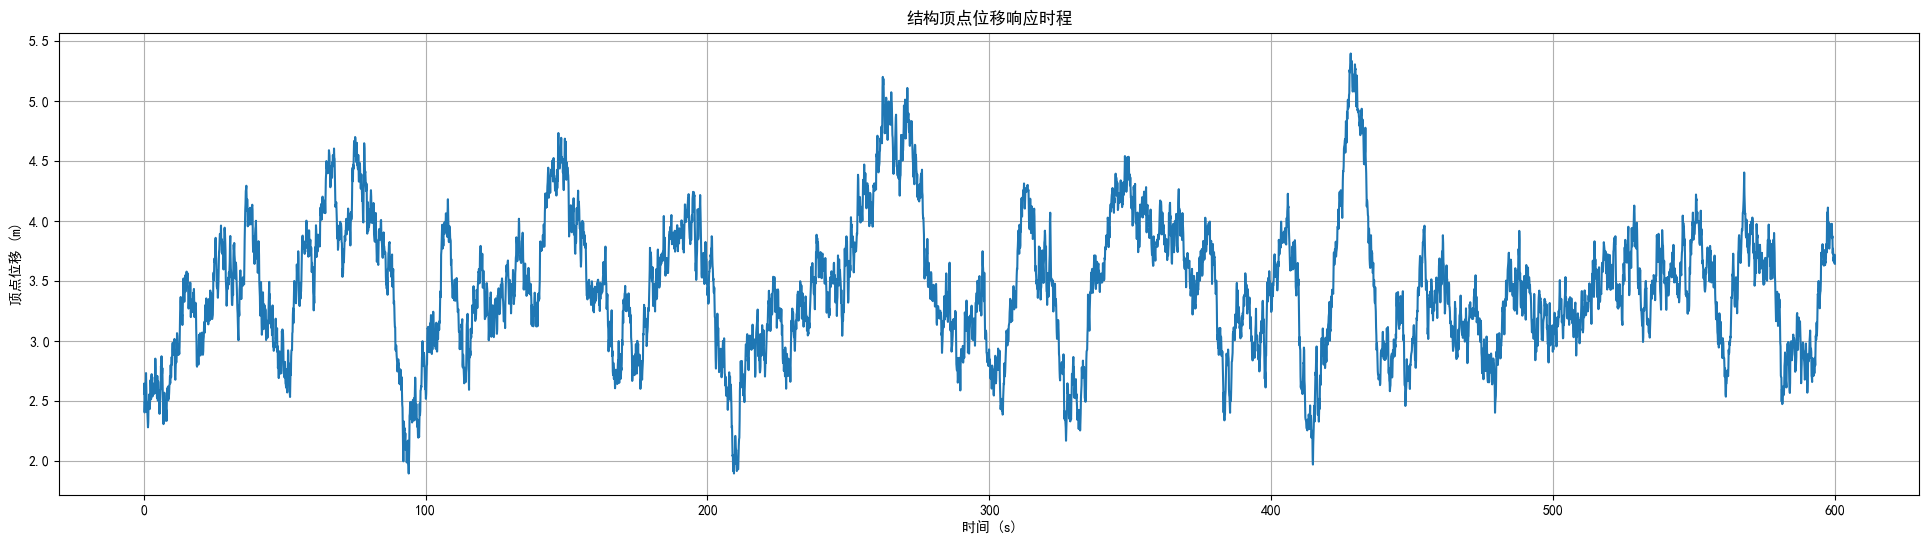

In [ ]:

# 设置matplotlib中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# 加载数据
simDataPath = './windData/windData.mat'
simData = sio.loadmat(simDataPath, squeeze_me=True, struct_as_record=False)
U = simData['U']
Z = simData['Z']
dt = simData['dt']
t = simData['t']

# 结构参数
H = 324.95  # 建筑物高度
B = 65.88   # 迎风面宽度
D = 35.5   # 横向宽度
T1 = 6.38  # 第一阶自振周期


# 高度比和振型
h_ratio = np.array([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
h_part_ratio = np.array([0, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.05])
mode_shape = np.array([0.0000, 0.0137, 0.0558, 0.1277, 0.2424, 0.3503, 0.4629, 0.5903, 0.7309, 0.8700, 1.0000])
mass = np.array([2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 1500])  # 单位: ton
area = B * D * h_part_ratio

# 初始化风荷载计算器
windload = WindLoadCalculator(H=H, B=B, D=D, mode_shape=mode_shape, terrain_type='C')
# 初始化基底弯矩
base_moment = float()
result = windload.calculate_static_wind_load()
# 1. GB 50009-2012规范计算
# 计算各层静态风荷载、基底弯矩
print("（1）静态风荷载计算结果：")
for i, load in enumerate(result):
    # 基底弯矩
    base_moment += area[i] * load * sum(h_ratio[:i] * H)
    print(f"\t高度 {i/10:.1f}H: \n \t \t 风压：{load:.2f} kN/m2; 风荷载： {area[i]*load:.2f} kN; 基底弯矩：{area[i]*load*sum(h_part_ratio[:i+1]*H):.2f} kN·m")
print("总基底弯矩：", f"{base_moment:.2f}", "kN·m")


# 2. 时域分析
structural_analysis = StructuralAnalysis(mass, mode_shape, T1)
y = structural_analysis.calculate_displacement()
y_top = y[:, -1]  # 顶点位移时程

# 计算极值响应
g = 2.5  # 峰值因子
y_max = np.mean(y_top) + g * np.std(y_top)



print(f"\n（2）基于时域分析的结果:")
print(f"\t顶点最大位移(m): {y_max:.4f}")
print(f"\t顶点平均位移(m): {np.mean(y_top):.4f}")
print(f"\t顶点位移标准差(m): {np.std(y_top):.4f}")

# 绘制响应时程
plt.figure(figsize=(24, 6))
plt.plot(t, y_top)
plt.xlabel('时间 (s)')
plt.ylabel('顶点位移 (m)')
plt.title('结构顶点位移响应时程')
plt.grid(True)
plt.show()